<h2>SIMPLIFIED ATTENTION MECHANISM</h2>

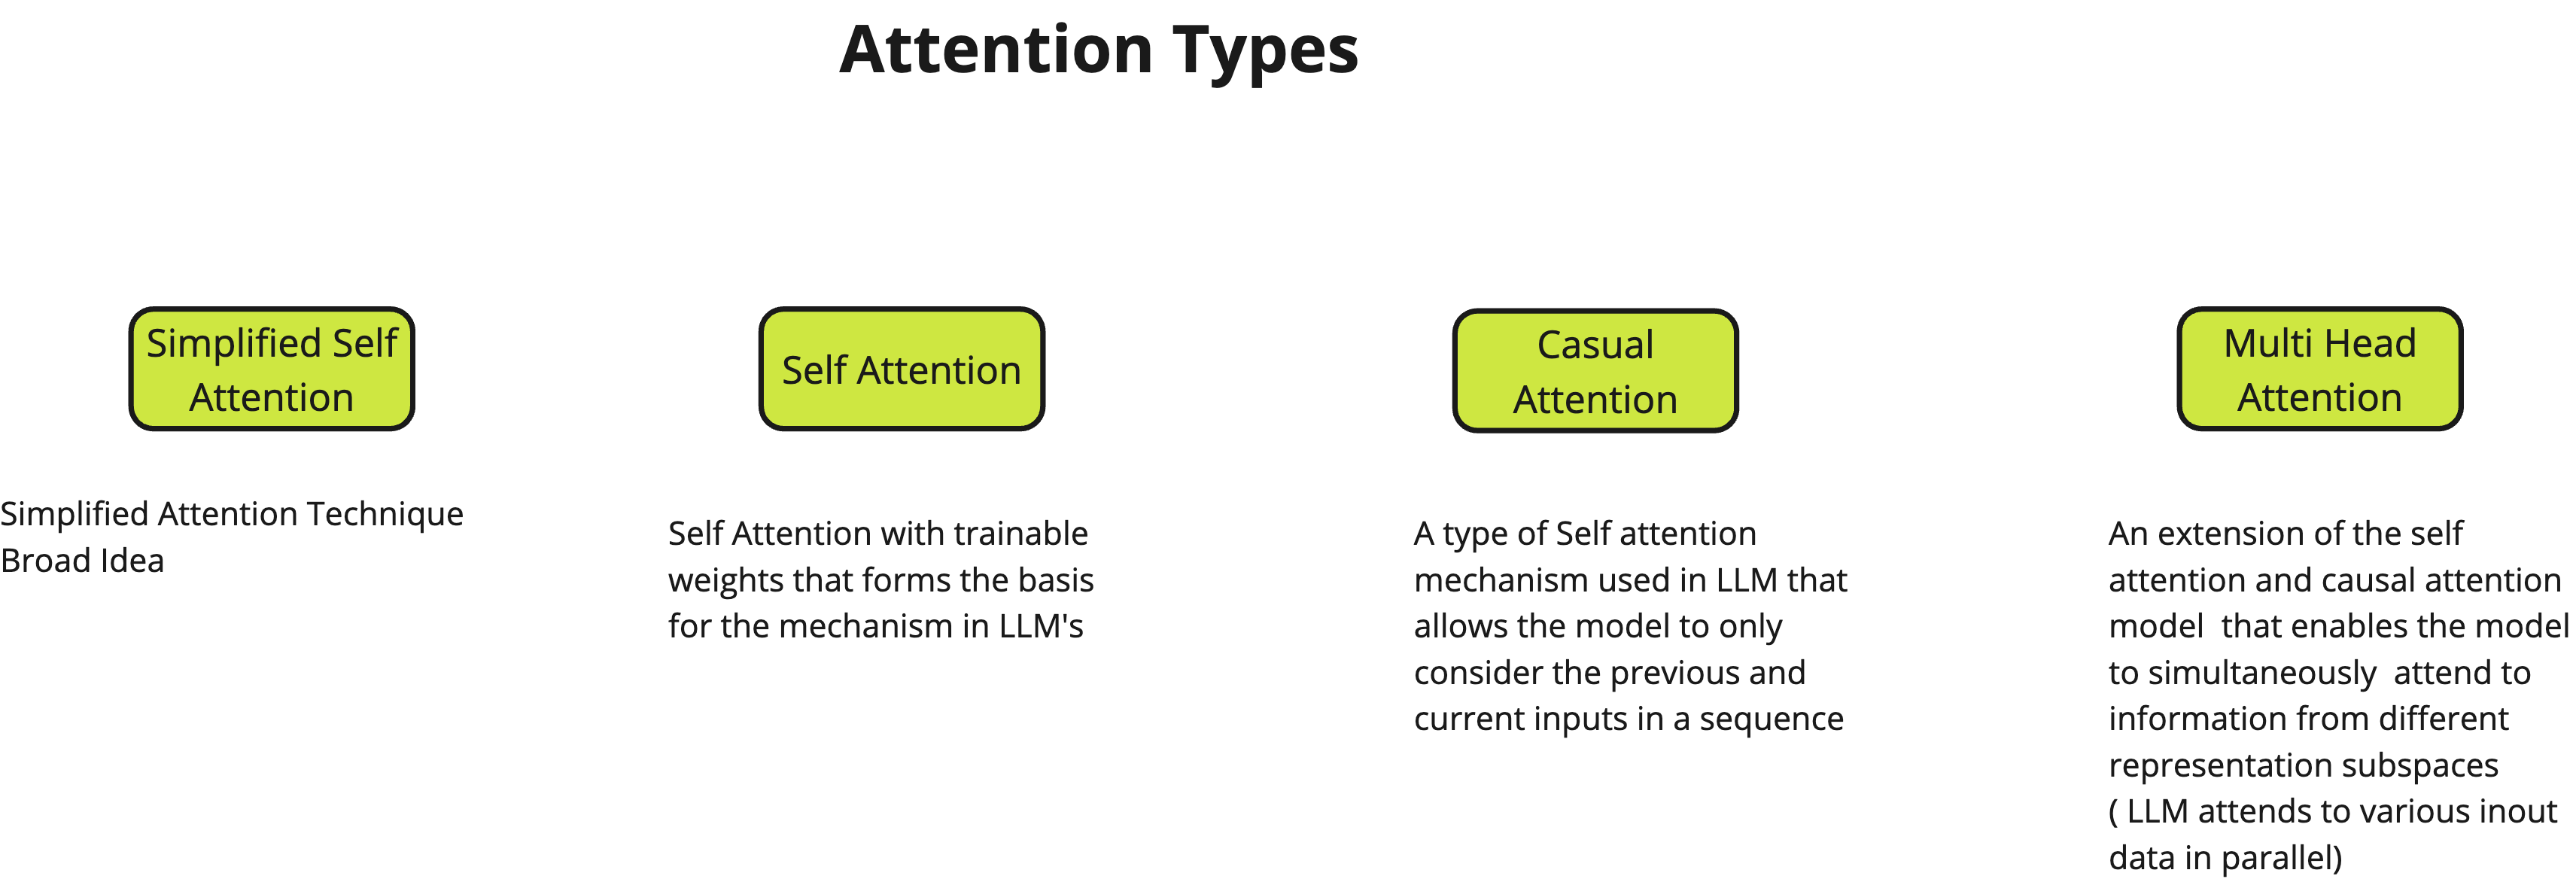

<div class="alert alert-block alert-success">

The input sentence is first processed by a tokenizer, which breaks it down into individual tokens. Each token is then transformed into an embedding that captures its semantic meaning. However, within a sentence, these embeddings do not reflect the relationships or significance of each word in relation to the others. They do not indicate how much attention should be given to different words for any given word in the sentence.

Our goal is to use the embedding vector for each word and create a context vector. This context vector can be seen as an enhanced version of the embedding vector, incorporating not only semantic information but also details on how the word interacts with other words in the sentence.
The contextual information is really useful in generating the next word.

Consider the following input sentence, "Your journey starts with one step" <br>
Input is handled by tokenizer and we get the embeddings for each token. By applying attention mechanism we generate a context for each word.This context not only conveys the semantic meaning but also the relationship of this word with other words in the sentence
<br>
<br>

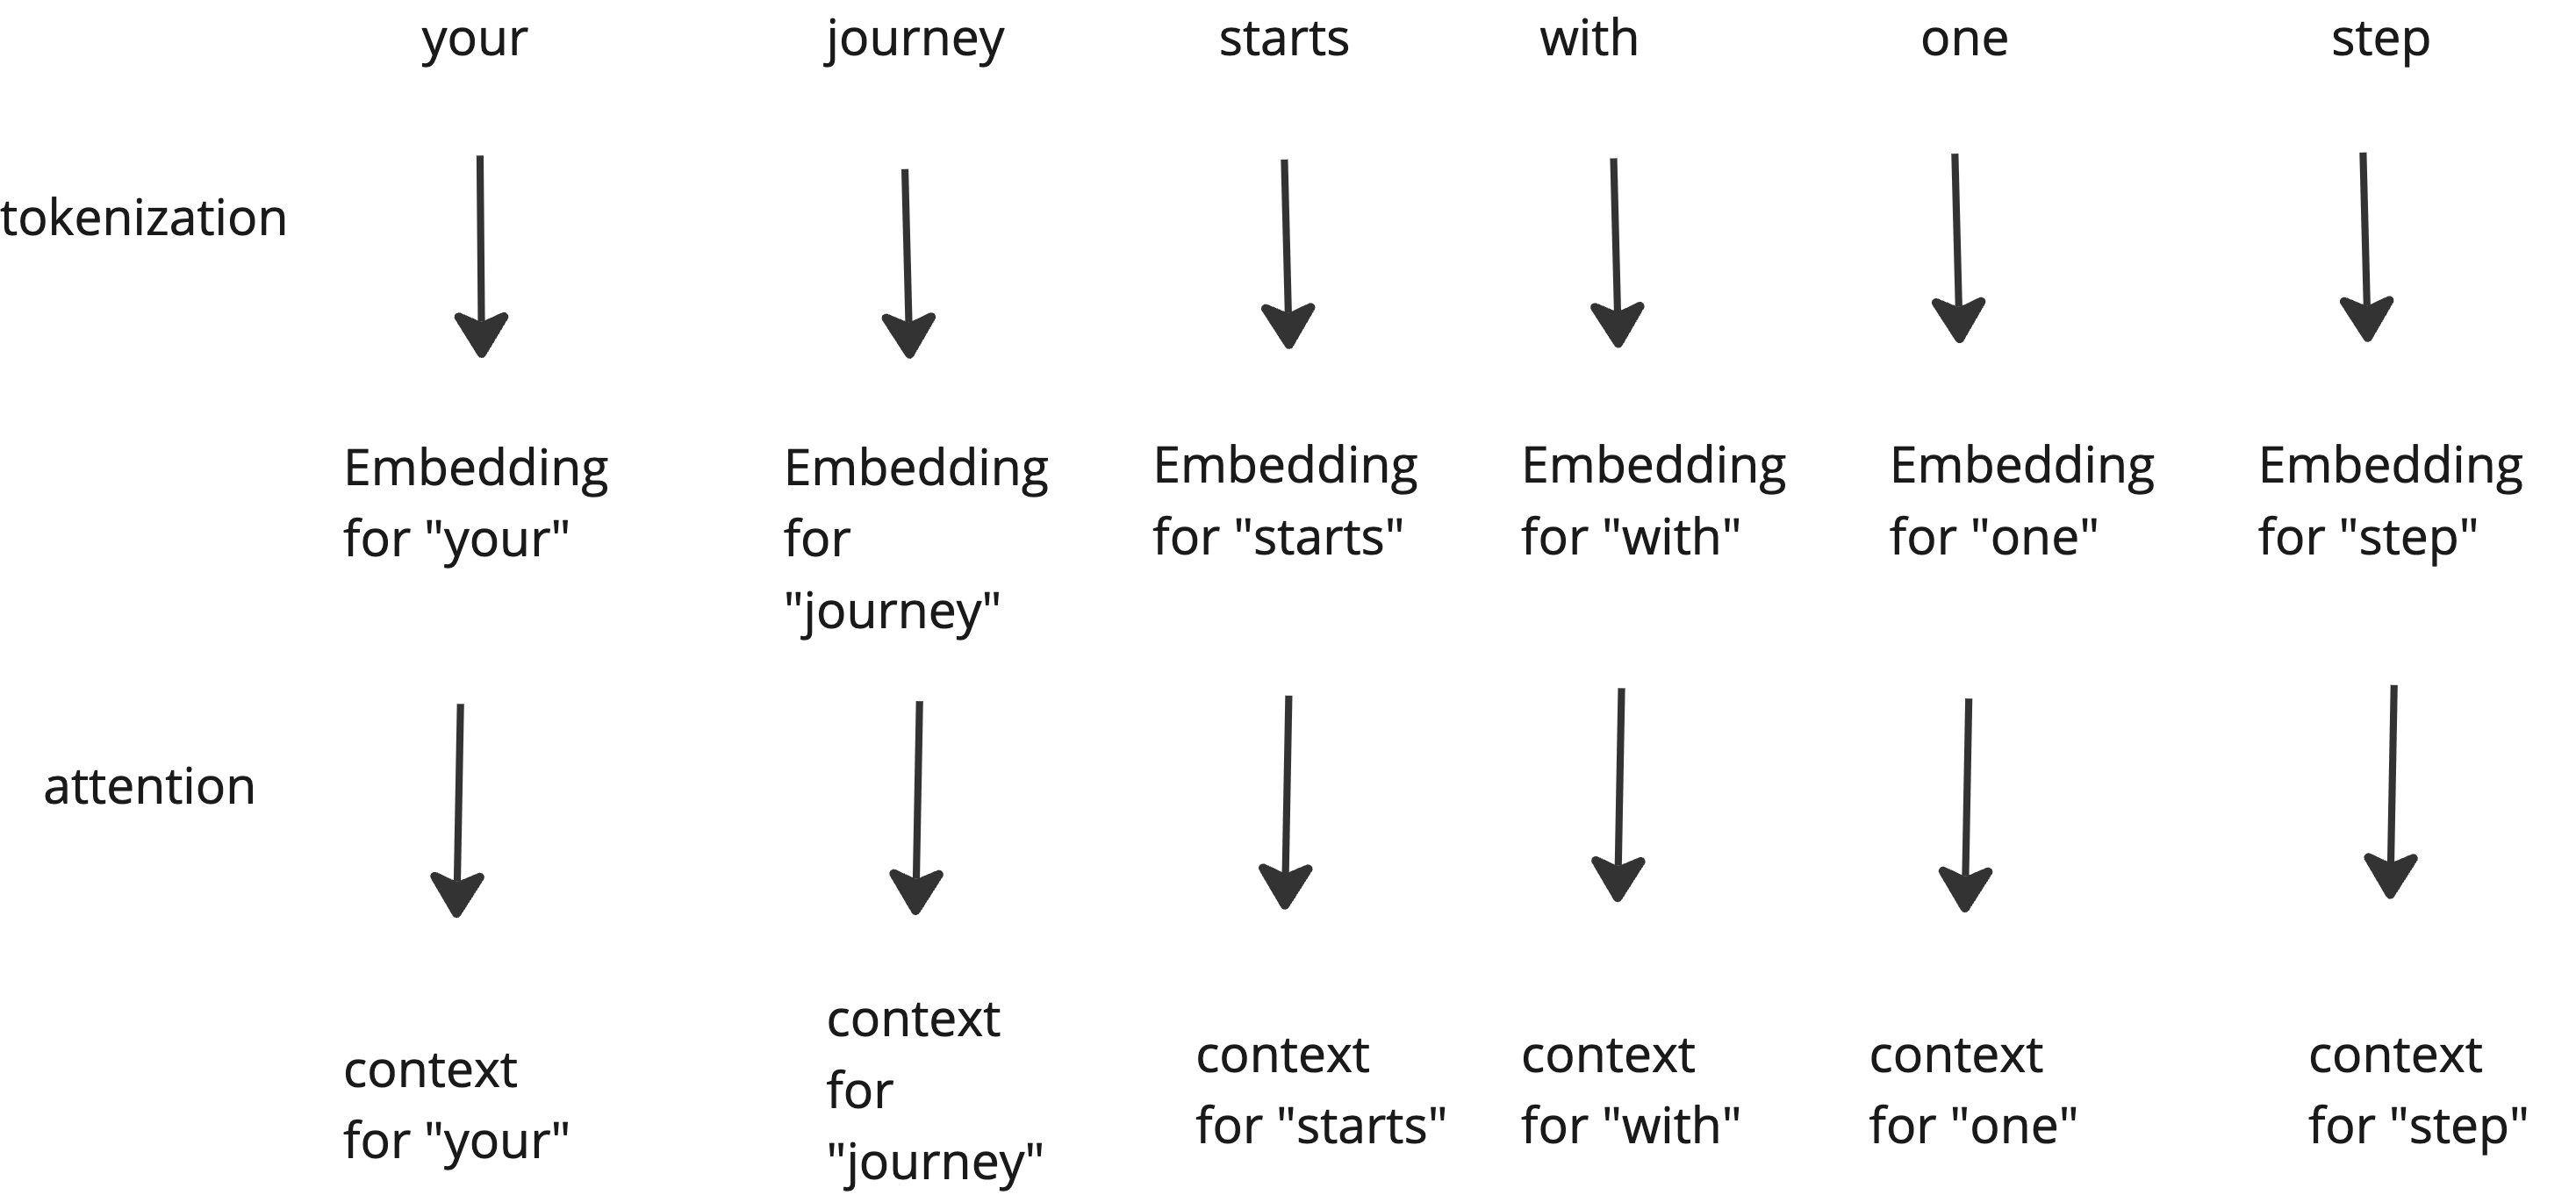


</div>

<div class="alert alert-block alert-success">
Consider the above input sentence, which has already been embedded into 3- dimensional vectors.
We choose a small embedding dimension for illustration purposes to ensure it fits on the page without line breaks:
</div>

In [1]:
import torch

inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

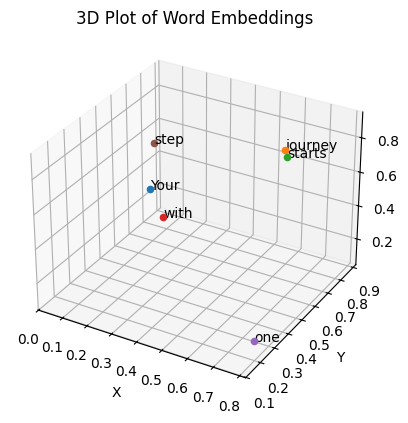

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Corresponding words
words = ['Your', 'journey', 'starts', 'with', 'one', 'step']

# Extract x, y, z coordinates
x_coords = inputs[:, 0].numpy()
y_coords = inputs[:, 1].numpy()
z_coords = inputs[:, 2].numpy()

# Create 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot each point and annotate with corresponding word
for x, y, z, word in zip(x_coords, y_coords, z_coords, words):
    ax.scatter(x, y, z)
    ax.text(x, y, z, word, fontsize=10)

# Set labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.title('3D Plot of Word Embeddings')
plt.show()

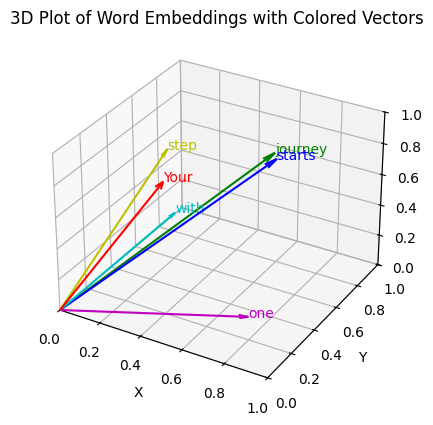

In [3]:
# Create 3D plot with vectors from origin to each point, using different colors
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Define a list of colors for the vectors
colors = ['r', 'g', 'b', 'c', 'm', 'y']

# Plot each vector with a different color and annotate with the corresponding word
for (x, y, z, word, color) in zip(x_coords, y_coords, z_coords, words, colors):
    # Draw vector from origin to the point (x, y, z) with specified color and smaller arrow length ratio
    ax.quiver(0, 0, 0, x, y, z, color=color, arrow_length_ratio=0.05)
    ax.text(x, y, z, word, fontsize=10, color=color)

# Set labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set plot limits to keep arrows within the plot boundaries
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_zlim([0, 1])

plt.title('3D Plot of Word Embeddings with Colored Vectors')
plt.show()


<div class="alert alert-block alert-info">

How do u calculate the attention weights for a given word wrt all other words in a sentence

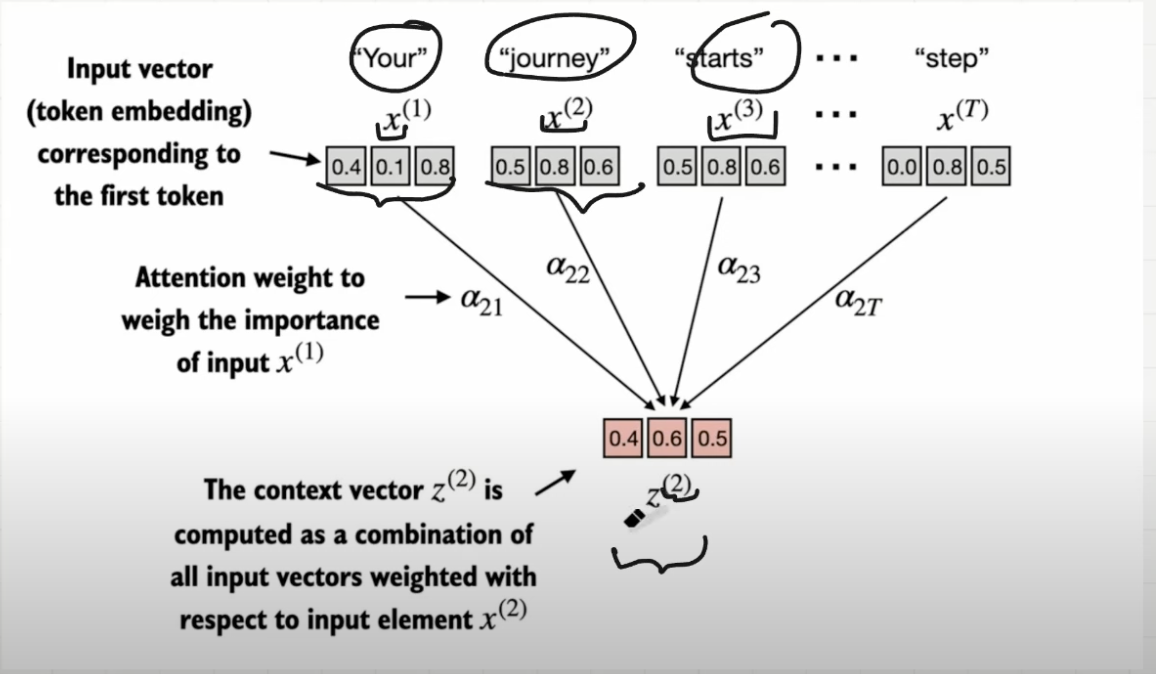

a21 is the attention weight of word x[1] for word x[2], similarly a22 is the attention weight of word x[2] for word x[2], similarly a23 is the attention weight of word x[3] for word x[2] and so on ..

Finally u combine the attention weights to generate the context vector

Context vector for word x[2] ("journey") is denoted by z[2]
</div>

<div class="alert alert-block alert-info">
Let us calculate the attenton weights for the 2nd input token. <br>    
This is also known as the query  <br>
How do you calculate the attention scores - simple way - dot product with each token in the sentence. It represents similarity/aliglment/importance of a given word with respect to other word
</div>

In [4]:
print(inputs.shape)

query = inputs[1]  # 2nd input token is the query

attn_scores_2 = torch.empty(inputs.shape[0])
for i, x_i in enumerate(inputs):
    attn_scores_2[i] = torch.dot(x_i, query) # dot product (transpose not necessary here since they are 1-dim vectors)

print(attn_scores_2)

torch.Size([6, 3])
tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


<div class="alert alert-block alert-success">

In the next step, we normalize each of the attention scores that
we computed previously. <br>
The main goal behind the normalization is to obtain attention weights that sum up to 1. <br>
This normalization is a convention that is useful for interpretation and for maintaining training stability in an LLM.

</div>

In [5]:
attn_weights_2_tmp = attn_scores_2 / attn_scores_2.sum()

print("Attention weights:", attn_weights_2_tmp)
print("Sum:", attn_weights_2_tmp.sum())

Attention weights: tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum: tensor(1.0000)


<div class="alert alert-block alert-info">
    
In practice, it's more common and advisable to use the softmax function for normalization.

This approach is better at managing extreme values and offers more favorable gradient
properties during training. 

Below is a basic implementation of the softmax function for
normalizing the attention scores: 
</div>

In [6]:
def softmax_naive(x):
    return torch.exp(x) / torch.exp(x).sum(dim=0)

attn_weights_2_naive = softmax_naive(attn_scores_2)

print("Attention weights:", attn_weights_2_naive)
print("Sum:", attn_weights_2_naive.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


<div class="alert alert-block alert-warning">

Note that this naive softmax implementation (softmax_naive) may encounter numerical
instability problems, such as overflow and underflow, when dealing with large or small input
values. 

Therefore, in practice, it's advisable to use the PyTorch implementation of softmax,
which has been extensively optimized for performance: <br>

Pytorch subtracts max_val from each element in the input vector. This shifts the values so that the maximum becomes zero. Since the maximum is now zero, the largest exponent is zero, preventing overflow. Also all values are within a reasonable range, preventing underflow.
    
</div>

In [7]:
attn_weights_2 = torch.softmax(attn_scores_2, dim=0)
print("Attention weights:", attn_weights_2)
print("Sum:", attn_weights_2.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


<div class="alert alert-block alert-success">

Now lets calculate context vector z[2] <br>
The context vector z(2)is calculated as a weighted sum of all input
vectors. 
This involves multiplying each input vector by its corresponding attention weight:

</div>

In [8]:
query = inputs[1] # 2nd input token is the query

context_vec_2 = torch.zeros(query.shape)
for i,x_i in enumerate(inputs):
    context_vec_2 += attn_weights_2[i]*x_i

print(context_vec_2)

tensor([0.4419, 0.6515, 0.5683])


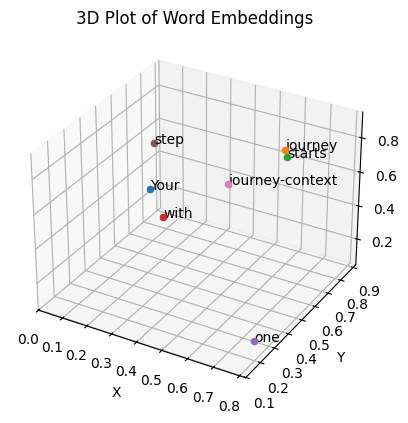

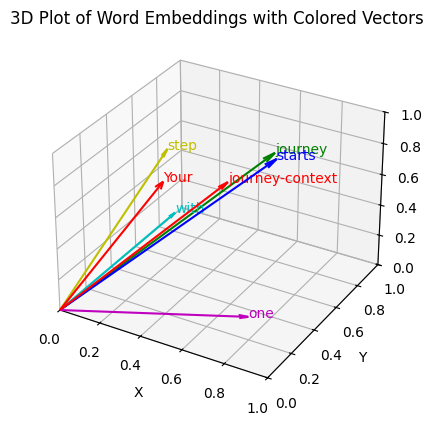

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55], # step     (x^6)
   [0.4419, 0.6515, 0.5683]]  #context vector for 2nd token  - journey
)

# Corresponding words
words = ['Your', 'journey', 'starts', 'with', 'one', 'step', 'journey-context']

# Extract x, y, z coordinates
x_coords = inputs[:, 0].numpy()
y_coords = inputs[:, 1].numpy()
z_coords = inputs[:, 2].numpy()

# Create 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot each point and annotate with corresponding word
for x, y, z, word in zip(x_coords, y_coords, z_coords, words):
    ax.scatter(x, y, z)
    ax.text(x, y, z, word, fontsize=10)

# Set labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.title('3D Plot of Word Embeddings')
plt.show()

# Create 3D plot with vectors from origin to each point, using different colors
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Define a list of colors for the vectors
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'r']

# Plot each vector with a different color and annotate with the corresponding word
for (x, y, z, word, color) in zip(x_coords, y_coords, z_coords, words, colors):
    # Draw vector from origin to the point (x, y, z) with specified color and smaller arrow length ratio
    ax.quiver(0, 0, 0, x, y, z, color=color, arrow_length_ratio=0.05)
    ax.text(x, y, z, word, fontsize=10, color=color)

# Set labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set plot limits to keep arrows within the plot boundaries
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_zlim([0, 1])

plt.title('3D Plot of Word Embeddings with Colored Vectors')
plt.show()

<div class="alert alert-block alert-success">

Now, we can extend this computation to
calculate attention weights and context vectors for all inputs.

</div>

<div class="alert alert-block alert-success">

First - simple way, we add an additional for-loop to compute the
dot products for all pairs of inputs.

</div>

In [10]:
attn_scores = torch.empty(6, 6)   #6 words , 6 attention scores for each word wrt to all the other words
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)
for i, x_i in enumerate(inputs):
    for j, x_j in enumerate(inputs):
        attn_scores[i, j] = torch.dot(x_i, x_j)

print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


<div class="alert alert-block alert-info">
    
Each element in the preceding tensor represents an attention score between each pair of
inputs.
</div>

<div class="alert alert-block alert-info">
    
When computing the preceding attention score tensor, we used for-loops in Python.
                                                            
However, for-loops are generally slow, and we can achieve the same results using matrix
multiplication:
</div>

In [11]:
attn_scores = inputs @ inputs.T
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


<div class="alert alert-block alert-success">

We now normalize each row so that the values in
each row sum to 1:

</div>

In [12]:
attn_weights = torch.softmax(attn_scores, dim=-1)
print(attn_weights)

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


<div class="alert alert-block alert-success">

Let's briefly verify that
the rows indeed all sum to 1:

</div>

In [13]:
print(attn_weights[0])

tensor([0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452])


In [14]:
row_2_sum = sum([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
print("Row 2 sum:", row_2_sum)
print("All row sums:", attn_weights.sum(dim=-1))  #last dimension - each row

Row 2 sum: 1.0
All row sums: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


<h3>Finally compute all contexts</h3>

<div class="alert alert-block alert-success">

In the third and last step, we now use these attention weights to compute all context
vectors via matrix multiplication:

</div>

In [15]:
all_context_vecs = attn_weights @ inputs
print(all_context_vecs)

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])
